In [24]:
# !pip install tensorflow-gpu matplotlib tqdm numpy seaborn

In [25]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.metrics import roc_curve
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import seaborn as sns
import re
import ast
import os


sns.set()
plt.rc('font', family = 'serif')
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['xtick.labelsize'] = 20
# plt.rcParams['ytick.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20 

In [26]:
class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

IMGWIDTH = 256

In [27]:
class Meso1(Classifier):
    """
    Feature extraction + Classification
    """
    def __init__(self, learning_rate = 0.001, dl_rate = 1):
        self.model = self.init_model(dl_rate)
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self, dl_rate):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(16, (3, 3), dilation_rate = dl_rate, strides = 1, padding='same', activation = 'relu')(x)
        x1 = Conv2D(4, (1, 1), padding='same', activation = 'relu')(x1)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(8, 8), padding='same')(x1)

        y = Flatten()(x1)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)
        return KerasModel(inputs = x, outputs = y)

In [28]:
class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)

In [29]:
class MesoInception4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate = learning_rate)
        self.model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
    
    def InceptionLayer(self, a, b, c, d):
        def func(x):
            x1 = Conv2D(a, (1, 1), padding='same', activation='relu')(x)
            
            x2 = Conv2D(b, (1, 1), padding='same', activation='relu')(x)
            x2 = Conv2D(b, (3, 3), padding='same', activation='relu')(x2)
            
            x3 = Conv2D(c, (1, 1), padding='same', activation='relu')(x)
            x3 = Conv2D(c, (3, 3), dilation_rate = 2, strides = 1, padding='same', activation='relu')(x3)
            
            x4 = Conv2D(d, (1, 1), padding='same', activation='relu')(x)
            x4 = Conv2D(d, (3, 3), dilation_rate = 3, strides = 1, padding='same', activation='relu')(x4)

            y = Concatenate(axis = -1)([x1, x2, x3, x4])
            
            return y
        return func
    
    def init_model(self):
        x = Input(shape = (IMGWIDTH, IMGWIDTH, 3))
        
        x1 = self.InceptionLayer(1, 4, 4, 2)(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = self.InceptionLayer(2, 4, 4, 2)(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)        
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return KerasModel(inputs = x, outputs = y)


In [30]:
def get_meso_model(model_name):
    if model_name == "Meso4_DF":
        model = Meso4()
        model.load("../_WEIGHTS/og_mesonet_weights/Meso4_DF.h5")
    elif model_name == "Meso4_F2F":
        model = Meso4()
        model.load("../_WEIGHTS/og_mesonet_weights/Meso4_F2F.h5")
    elif model_name == "MesoInception_DF":
        model = MesoInception4()
        model.load("../_WEIGHTS/og_mesonet_weights/MesoInception_DF.h5")
    elif model_name == "MesoInception_F2F":
        model = MesoInception4()
        model.load("../_WEIGHTS/og_mesonet_weights/MesoInception_F2F.h5")
    return model


In [31]:
def get_binary_testset(dataset_name):
    """
    `DariusAf_Deepfake_Database` (train_test)
    `Celeb-avg-30-test`
    `Celeb-rnd-30-test`
    `Celeb-diff-30-test`
    """
    if dataset_name == "DariusAf_Deepfake_Database":
        testset = "../_DATASETS/DariusAf_Deepfake_Database/train_test"
    elif dataset_name == "Celeb-avg-30-test":
        testset = "../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
    elif dataset_name == "Celeb-rnd-30-test":
        testset = "../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
    elif dataset_name == "Celeb-diff-30-test":
        testset = "../_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"
    return testset

In [32]:
SEED = 1337
# CLASSIFIER = get_meso_model("Meso4_DF")
# DATASET = get_binary_testset("DariusAf_Deepfake_Database")

In [33]:
# IMG_DATAGEN = ImageDataGenerator(rescale=1./255)
# GEN = IMG_DATAGEN.flow_from_directory(DATASET,
#                                       target_size=(IMGWIDTH, IMGWIDTH),
#                                       batch_size=128,
#                                       seed=SEED,
#                                       class_mode="binary") 
# possible_batch_sizes = [b for b in range(1, GEN.samples) if not GEN.samples % b]
# possible_batch_sizes = [b for b in possible_batch_sizes if b<4096][::-1]
# GEN.batch_size = possible_batch_sizes[0]

# print(f"Possible batch sizes: {possible_batch_sizes}")
# print(f"Chosen batch size: {GEN.batch_size}")

In [34]:
              # experiment_name,                                       model_name,          testset_name,                 fname
EXPERIMENTS = [ # ROUND 1, Default MesoNets w/ dataset provided by paper author
               ("Meso4 w/ DF Weights \nTested on DFDB Dataset",          "Meso4_DF",           "DariusAf_Deepfake_Database", "Meso4_DF_DFDB"),
               ("Meso4 w/ F2F Weights \nTested on DFDB Dataset",         "Meso4_F2F",          "DariusAf_Deepfake_Database", "Meso4_F2F_DFDB"),
               ("MesoInception4 w/ DF Weights \nTested on DFDB Dataset", "MesoInception_DF",   "DariusAf_Deepfake_Database", "MesoInception_DF_DFDB"),
               ("MesoInception4 w/ F2F Weights \nTested on DFDB Dataset", "MesoInception_F2F", "DariusAf_Deepfake_Database", "MesoInception_F2F_DFDB"),

                # ROUND 2, MesoInception_DF_DFDB and Meso4_DF_DFDB heightest AUC at 0.990 and 0.984, respectively
               ("MesoInception4 w/ DF Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)",         "MesoInception_DF",  "Celeb-avg-30-test", "MesoInception_DF_CDFv2avg"),

               ("MesoInception4 w/ DF Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)",   "MesoInception_DF",  "Celeb-rnd-30-test", "MesoInception_DF_CDFv2rnd"),

               ("Meso4 w/ DF Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)",         "Meso4_DF",          "Celeb-avg-30-test", "Meso4_DF_CDFv2avg"),

               ("Meso4 w/ DF Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)",   "Meso4_DF",          "Celeb-rnd-30-test", "Meso4_DF_CDFv2rnd"),

               # ROUND 2.1, Just to check... performance of F2F equivielents (allows us to rule out avg datasets)
               ("MesoInception4 w/ F2F Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)",         "MesoInception_F2F", "Celeb-avg-30-test", "MesoInception_F2F_CDFv2avg"),

               ("MesoInception4 w/ F2F Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)",   "MesoInception_F2F", "Celeb-rnd-30-test", "MesoInception_F2F_CDFv2rnd"),

               ("Meso4 w/ F2F Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)",         "Meso4_F2F",         "Celeb-avg-30-test", "Meso4_F2F_CDFv2avg"),

               ("Meso4 w/ F2F Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)",   "Meso4_F2F",         "Celeb-rnd-30-test", "Meso4_F2F_CDFv2rnd"),

               # ROUND 2.2, Running AVG, set of images from each video is single data point
               ("MesoInception4 w/ DF Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation", "MesoInception_DF", "Celeb-avg-30-test", "MesoInception_DF_CDFv2runningavg"),

               ("MesoInception4 w/ DF Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",  "MesoInception_DF", "Celeb-rnd-30-test", "MesoInception_DF_CDFv2runningrnd"),

               ("Meso4 w/ DF Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",  "Meso4_DF", "Celeb-avg-30-test", "Meso4_DF_CDFv2runningavg"),

               ("Meso4 w/ DF Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",  "Meso4_DF", "Celeb-rnd-30-test", "Meso4_DF_CDFv2runningrnd"),

               ("MesoInception4 w/ F2F Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",   "MesoInception_F2F", "Celeb-avg-30-test", "MesoInception_F2F_CDFv2runningavg"),

               ("MesoInception4 w/ F2F Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",  "MesoInception_F2F", "Celeb-rnd-30-test", "MesoInception_F2F_CDFv2runningrnd"),

               ("Meso4 w/ F2F Weights\
               \nTested on AVG CDFv2 Dataset\
               \n(Average Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",  "Meso4_F2F", "Celeb-avg-30-test", "Meso4_F2F_CDFv2runningavg"),

               ("Meso4 w/ F2F Weights\
               \nTested on RND CDFv2 Dataset\
               \n(Single Random Face Frames Every 0.5s Interval)\
               \nRunning Average Evaluation",  "Meso4_F2F", "Celeb-rnd-30-test", "Meso4_F2F_CDFv2runningrnd"),

               ]

Found 12353 images belonging to 2 classes.


100%|██████████| 386/386 [03:28<00:00,  1.85it/s]


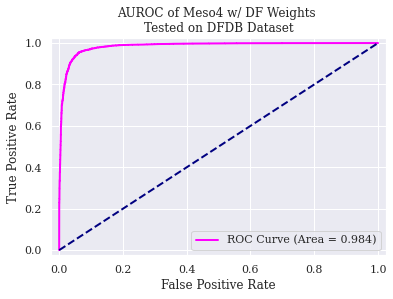

Found 12353 images belonging to 2 classes.


100%|██████████| 386/386 [00:35<00:00, 10.85it/s]


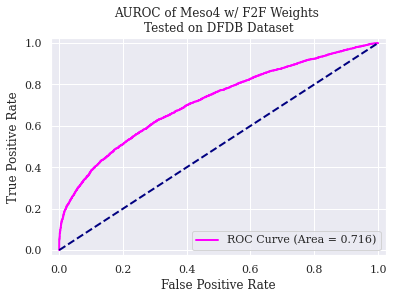

Found 12353 images belonging to 2 classes.


100%|██████████| 386/386 [00:39<00:00,  9.82it/s]


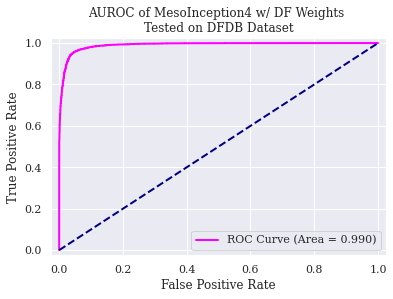

Found 12353 images belonging to 2 classes.


100%|██████████| 386/386 [00:38<00:00,  9.96it/s]


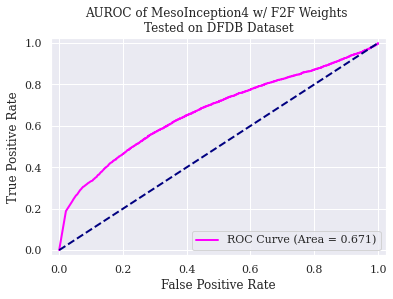

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [05:15<00:00,  1.94it/s]


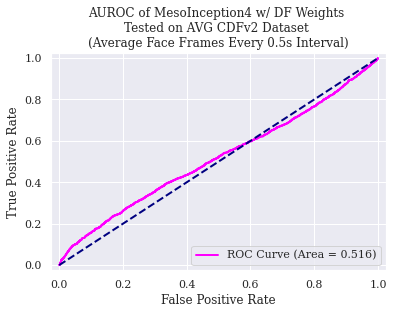

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [05:01<00:00,  2.04it/s]


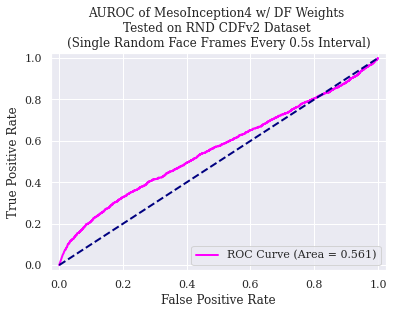

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [00:57<00:00, 10.73it/s]


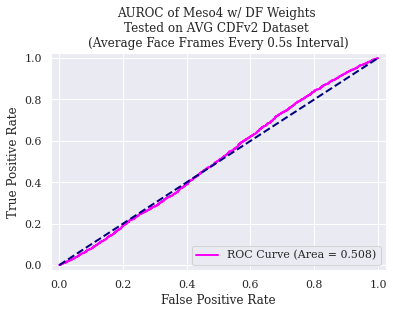

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [00:57<00:00, 10.70it/s]


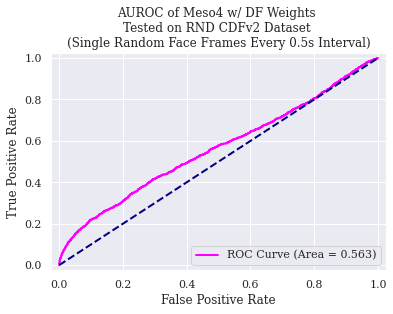

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [01:02<00:00,  9.85it/s]


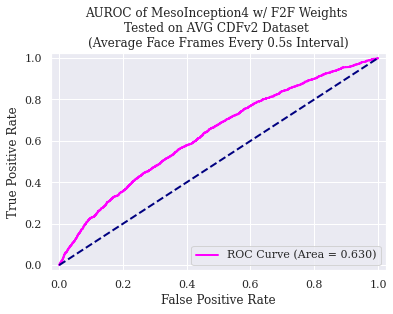

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [01:01<00:00, 10.02it/s]


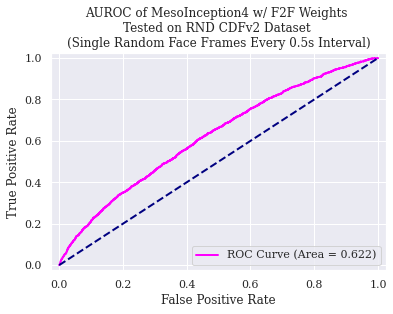

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [00:55<00:00, 11.03it/s]


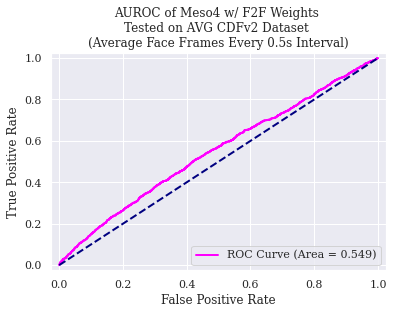

Found 19638 images belonging to 2 classes.


100%|██████████| 613/613 [00:56<00:00, 10.83it/s]


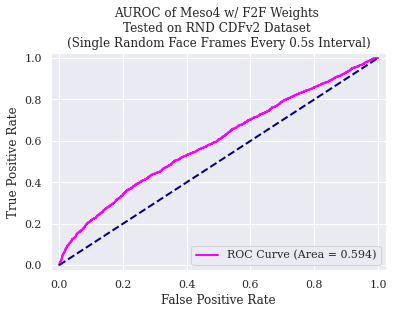

Found 19638 images belonging to 2 classes.


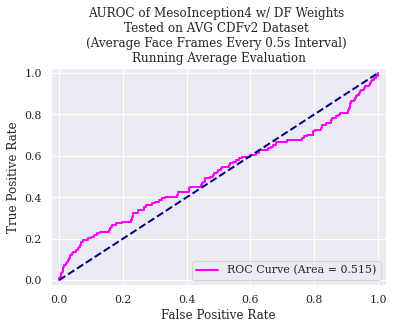

Found 19638 images belonging to 2 classes.


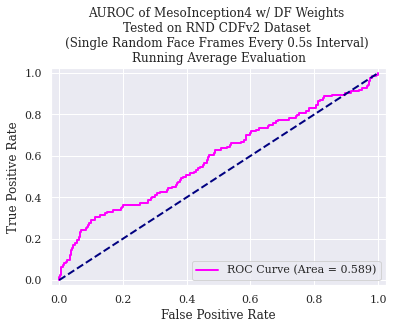

Found 19638 images belonging to 2 classes.


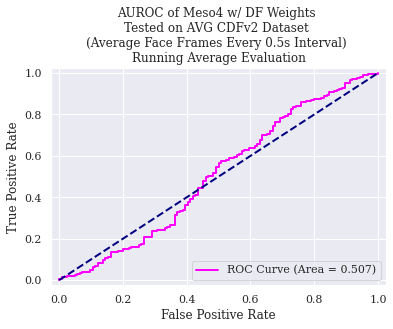

Found 19638 images belonging to 2 classes.


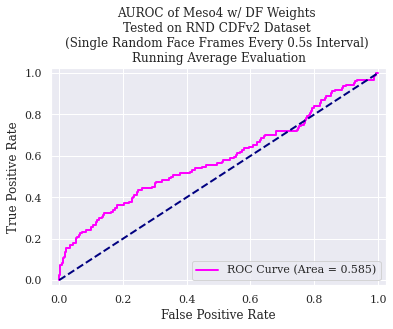

Found 19638 images belonging to 2 classes.


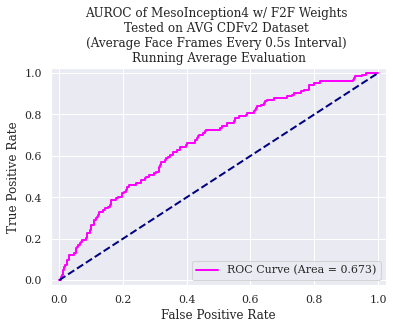

Found 19638 images belonging to 2 classes.


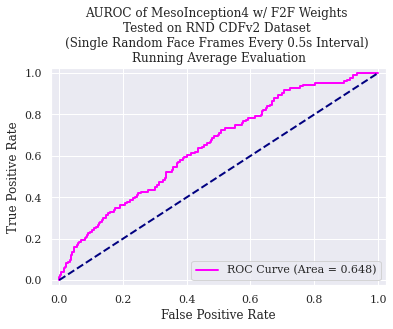

Found 19638 images belonging to 2 classes.


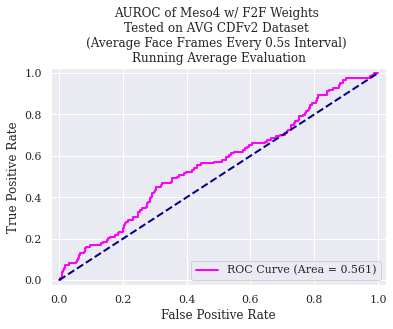

Found 19638 images belonging to 2 classes.


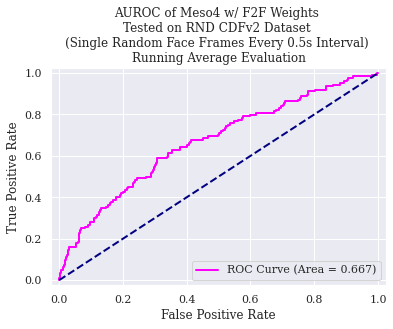

In [35]:
for experiment_name, model_name, testset_name, fname in EXPERIMENTS:
    fname = f"./Results/{fname}"

    # Pick the correct model
    CLASSIFIER = get_meso_model(model_name)
    DATASET = get_binary_testset(testset_name)

    IMG_DATAGEN = ImageDataGenerator(rescale=1./255)
    GEN = IMG_DATAGEN.flow_from_directory(DATASET,
                                          target_size=(IMGWIDTH, IMGWIDTH),
                                        #   batch_size=128,
                                          seed=SEED,
                                          class_mode="binary") 
    # possible_batch_sizes = [b for b in range(1, GEN.samples) if not GEN.samples % b]
    # possible_batch_sizes = [b for b in possible_batch_sizes if b<2000][::-1]
    # GEN.batch_size = possible_batch_sizes[0]

    # Evaluate model on test set
    # print(experiment_name)
    if "Running" in experiment_name: # if running in experiment name
        # running average eval, set of images from each video is single data point (not indep.)
        path_to_testset_real_class = f"{DATASET}/{[d for d in os.listdir(DATASET) if 'real' in d][0]}"
        path_to_testset_fake_class = f"{DATASET}/{[d for d in os.listdir(DATASET) if 'real' not in d][0]}"

        y_pred = []
        y_true = []
        for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
            img_dir_list = os.listdir(y_dir_pth)
            Vpths = []
            # loop over all single videos
            for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

                all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
                path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
                V = []

                # loop over all frames from single video
                for path_to_test_img in path_all_imgs_for_vid:
                    t = load_img(path_to_test_img, target_size=(IMGWIDTH, IMGWIDTH))
                    V += [img_to_array(t)]
                V = np.array(V)**1./255
                y_pred += [np.average(CLASSIFIER.predict(V)).tolist()]
                y_true += [y_label]

    else:
    # normal eval, each image is single data point (indep.)
        y_pred = []
        y_true = []
        for b, (X, y) in tqdm(enumerate(GEN), total=len(GEN)-1):
            y_pred += CLASSIFIER.predict(X).tolist() 
            y_true += y.tolist()
            if b >= (GEN.samples / GEN.batch_size) - 1:
                break
    # y_pred = [yp.tolist() for yp in y_pred]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_rint = np.rint(y_pred)

    # Get AUC
    auroc = roc_auc_score(y_true, y_pred)
    fpr, tpr, _  = roc_curve(y_true, y_pred)

    # If model is worse than random but so much worse that, it's predicting the opposite way
    if auroc < .5:
        auroc = 1 - auroc
        fpr, tpr = tpr, fpr
        y_pred = np.ones(y_pred.shape) - y_pred

    # Get F1, Precision and Recall
    f1 = f1_score(y_true, y_pred_rint)
    prec = precision_score(y_true, y_pred_rint)
    recall = recall_score(y_true, y_pred_rint)
    
    # Plot AUC
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    extra_xylim = 0.025
    plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"AUROC of {experiment_name}")
    plt.legend(loc="lower right")
    plt.savefig(f"{fname}.png") # Save AUC fig
    plt.show()
    
    with open(f"{fname}.txt", "w") as f:
        f.write(f"{experiment_name, model_name, testset_name, fname}\n")
        f.write(f"{auroc=}\n")
        f.write(f"{f1=}\n")
        f.write(f"{prec=}\n")
        f.write(f"{recall=}\n")
        f.write(f"\nfpr={[f for f in fpr]}\n")
        f.write(f"\ntpr={[t for t in tpr]}\n")
        f.write(f"\ny_true={[t for t in y_true]}\n")
        f.write(f"\ny_pred={[p[0] if 'arr' in str(type(p)) and len(p) else p for p in y_pred]}")

In [36]:
fpath2results = "./Results/"
txt_files_in_results = os.listdir(fpath2results)
avg_files = [f"{fpath2results}{f}" for f in txt_files_in_results if "avg.txt" in f]
rnd_files = [f"{fpath2results}{f}" for f in txt_files_in_results if "rnd.txt" in f]

def get_auc_from_file(fpath):
    with open(fpath, "r") as f:
        f.readline()
        auc = f.readline()
    return float(auc.strip().split("=")[-1])

def get_ytrueNpreds_from_file(fpath):
    with open(fpath, "r") as f:
        lines = f.readlines()
        y_true, y_pred = lines[10], lines[12]
    return ast.literal_eval(y_true.split("=")[-1]), ast.literal_eval(y_pred.split("=")[-1])


avg_ytrue, avg_ypred = get_ytrueNpreds_from_file(avg_files[0])
rnd_ytrue, rnd_ypred = get_ytrueNpreds_from_file(rnd_files[0])
yy_true = rnd_ypred
# avg_ypred == rnd_ypred # TRUE

rnd_aucs = np.array([get_auc_from_file(f) for f in rnd_files])
avg_aucs = np.array([get_auc_from_file(f) for f in avg_files])

(avg_aucs.mean(), avg_aucs.std()), (rnd_aucs.mean(), rnd_aucs.std())

((0.557377636198922, 0.05834409033818056),
 (0.6035184137761789, 0.03609878027785385))

In [39]:
# [re.split('_\d+.png', img_name) for img_name in os.listdir(y_dir_pth)]

In [40]:


# path_to_testset = get_binary_testset("DariusAf_Deepfake_Database")
# path_to_testset_real_class = f"{path_to_testset}/{[d for d in os.listdir(path_to_testset) if 'real' in d][0]}"
# path_to_testset_fake_class = f"{path_to_testset}/{[d for d in os.listdir(path_to_testset) if 'real' not in d][0]}"

# # path_to_testset_real_class, path_to_testset_fake_class

# # path_to_testset_subdir = path_to_testset_fake_class

# # imgs_in_real_dir = os.listdir(path_to_testset_subdir)
# # img_name = imgs_in_real_dir[0]

# # y_pred += CLASSIFIER.predict(X).tolist() 
# # y_true += y.tolist()

# CLASSIFIER = get_meso_model("Meso4_DF")

# y_pred = []
# y_true = []
# for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
#     img_dir_list = os.listdir(y_dir_pth)
#     Vpths = []
#     # for img_name in img_dir_list:
#     #     split_img_name = re.split('_\d+.png', img_name)
#     #     og_fname = split_img_name[0]

#     # loop over all single videos
#     for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

#         all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
#         path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
#         V = []

#         # loop over all frames from single video
#         for path_to_test_img in path_all_imgs_for_vid:
#             t = load_img(path_to_test_img, target_size=(IMGWIDTH, IMGWIDTH))
#             V += [img_to_array(t)]
#         V = np.array(V)**1./255
#         y_pred += [np.average(CLASSIFIER.predict(V)).tolist()]
#         y_true += [y_label]#.tolist()

#         # if len(path_all_imgs_for_vid):
#         #     Vpths += [path_all_imgs_for_vid]
            
#         # break
# y_pred, y_true
# # Vpths[0]
#     # split_img_name = re.split('_\d+.png', img_name)
# # og_fname = split_img_name[0]

# # all_imgs_for_vid = [i for i in imgs_in_real_dir if og_fname in i]
# # path_all_imgs_for_vid = [f"{path_to_testset_subdir}/{i}" for i in all_imgs_for_vid]
# # path_all_imgs_for_vid

# # V = []
# # for path_to_test_img in path_all_imgs_for_vid:
# #     t = load_img(path_to_test_img, target_size=(IMGWIDTH, IMGWIDTH))
# #     V += [img_to_array(t)]
# # V = np.array(V)**1./255

# # # CLASSIFIER = get_meso_model("Meso4_DF")
# # CLASSIFIER.predict(V)#.tolist() 

In [41]:
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# y_pred_rint = np.rint(y_pred)

# # Get AUC
# auroc = roc_auc_score(y_true, y_pred)
# fpr, tpr, _  = roc_curve(y_true, y_pred)

# # If model is worse than random but so much worse that, it's predicting the opposite way
# if auroc < .5:
#     auroc = 1 - auroc
#     fpr, tpr = tpr, fpr

# # Get F1, Precision and Recall
# f1 = f1_score(y_true, y_pred_rint)
# prec = precision_score(y_true, y_pred_rint)
# recall = recall_score(y_true, y_pred_rint)

# # Plot AUC
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# extra_xylim = 0.025
# plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
# plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# # plt.title(f"{experiment_name} AUROC")
# plt.legend(loc="lower right")
# plt.savefig(f"{fname}.png") # Save AUC fig
# plt.show()

In [42]:
# y_pred = []
# y_true = []

# for b, (X, y) in tqdm(enumerate(GEN), total=len(GEN)):
#     y_pred += CLASSIFIER.predict(X).tolist()
#     y_true += y.tolist()
#     if b >= (GEN.samples / GEN.batch_size) - 1:
#         break

In [43]:
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)
# y_pred_rint = np.rint(y_pred)

In [44]:
# auroc = roc_auc_score(y_true, y_pred)
# fpr, tpr, _  = roc_curve(y_true, y_pred)

# # model is worse than random but so much worse that, it's predicting the opposite way
# if auroc < .5:
#     auroc = 1 - auroc
#     fpr, tpr = tpr, fpr

# f1 = f1_score(y_true, y_pred_rint)
# prec = precision_score(y_true, y_pred_rint)
# recall = recall_score(y_true, y_pred_rint)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auroc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()